In [1]:
import re
import os
import json
import time
from PIL import Image

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import ttest_ind

import faiss
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer
from transformers import AutoProcessor, AutoModelForCausalLM

root = "results/"
image_root = "F:/train_blocks"

In [48]:
sentence_bert = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [2]:
tokenizer = AutoTokenizer.from_pretrained("clip-rsicd")
model = CLIPModel.from_pretrained("clip-rsicd")
processor = CLIPProcessor.from_pretrained("clip-rsicd")

In [3]:
clip_model = CLIPModel.from_pretrained("clip-model")

In [4]:
git_processor = AutoProcessor.from_pretrained("microsoft/git-base")
git_model = AutoModelForCausalLM.from_pretrained("git-base-satellite")

In [5]:
def cap_post_process(caption):
    answers = []
    
    caps = re.split("CAP\s*\d*\s*[:=-]", caption)[1:]
    for cap in caps:
        if re.search("\d{2,}", cap):
            continue
        cap = cap.strip()
        cap = re.sub("^[\'\"]", "", cap)
        cap = re.sub("[\'\"]$", "", cap)
        answers.append(cap)
    return answers

def record_post_process(record):
    answers = {}
    
    for key, item in record.items():
        extracted_captions = []
        for caption in item["response"]:
            
            extracted_captions.extend(cap_post_process(caption))
        answers[key] = extracted_captions
    
    return answers

In [7]:
records = {}

for file_name in os.listdir(root):
    file_name_capture = re.search("records_(\d_[0-9]\d?).json", file_name)
    if file_name_capture:
        file_id = file_name_capture.group(1)
        
        with open(os.path.join(root, file_name), "r") as f:
            record = record_post_process(json.load(f))
        
        if len(record) == 0:
            continue
        records[file_id] = record

In [6]:
with open("results/unique_blocks_info.json", "r") as f:
    samples = json.load(f)

In [7]:
with open("results/records_0_0.json", "r") as f:
    responses = record_post_process(json.load(f))

In [8]:
responses_keys = list(responses.keys())
# records_keys = list(records.keys())

In [9]:
samples_data = []

for idx, key in enumerate(responses_keys):
    sample = samples[key]
    objects = [box["properties"]["type_id"] for box in sample["boxes"]]
    
    row = [
        idx,
        key,
        len(objects),
        len(set(objects)),
        objects
    ]
    
    samples_data.append(row)
    
samples_df = pd.DataFrame(samples_data, columns=["index", "key", "length", "nunique", "objects"])

In [41]:
# images = []

# for key in samples_keys:
#     file_path = os.path.join(image_root, f"{key}.png")
#     if os.path.isfile(file_path):
#         images.append(file_path)

In [104]:
def generate_dummy_captions(objects):
    all_sentences = []

    for verb in ["scattered", "dispersed", "spread"]:
        objects_lst = []
        for name, cnt in zip(*np.unique(objects, return_counts=True)):
            objects_lst.append(f"{cnt} {name}")

        objects_str = ", ".join(objects_lst[:-1]) + ", and " + objects_lst[-1]
        sentence = f"{objects_str} are {verb} across an aerial image.".lower()
        sentence_repl = re.sub("\d+", "some", sentence.replace("1", "one"))

        all_sentences.append(sentence)
        all_sentences.append(sentence_repl)
    
    return all_sentences

In [49]:
dummy_captions = generate_dummy_captions(samples_df.loc[samples_df["key"] == key, "objects"].tolist()[0])

  0%|                                                                                         | 0/1477 [00:00<?, ?it/s]

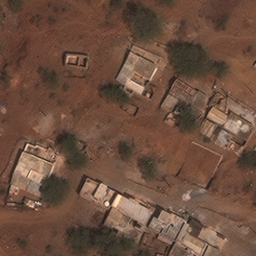

  0%|                                                                                         | 0/1477 [00:02<?, ?it/s]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
joint score 18.29, dummy score 0.6234837174415588: The buildings are dispersed with no clear clustering or formation.
joint score 17.89, dummy score 0.5761404633522034: The buildings are spread out with no apparent formation.
joint score 17.89, dummy score 0.428436279296875: Overall, the buildings in the aerial image appear to be scattered around without any significant clustering or formations.
joint score 17.00, dummy score 0.40598899126052856: The buildings are dispersed across the image with no clear pattern.
joint score 16.95, dummy score 0.4034755229949951: The buildings are dispersed throughout the image, with some located closer together than others.


In [103]:
for key, captions in tqdm(responses.items()):
    image = Image.open(os.path.join(image_root, f"{key}.png"))
    captions_with_title = [f"ChatGPT: {cap}" for cap in captions]
    
    rsicd_inputs = processor(text=captions, images=image, return_tensors="pt", padding=True)
    rsicd_scores = model(**rsicd_inputs).logits_per_image[0].detach().numpy()    
    rsicd_selected_indices = np.argsort(-rsicd_scores)[:10]
    rsicd_selected_scores = rsicd_scores[rsicd_selected_indices]
    rsicd_selected_captions = [captions[i] for i in rsicd_selected_indices]
    
    dummy_captions = generate_dummy_captions(samples_df.loc[samples_df["key"] == key, "objects"].tolist()[0])
    captions_embed = sentence_bert.encode(rsicd_selected_captions)
    dummy_embeds = sentence_bert.encode(dummy_captions)
    
    numerator = np.matmul(captions_embed, dummy_embeds.transpose())
    captions_norm = np.linalg.norm(captions_embed, axis=1, keepdims=True)
    dummy_norm = np.linalg.norm(dummy_embeds.transpose(), axis=0, keepdims=True)
    denominator = np.matmul(captions_norm, dummy_norm)

    sims = np.mean(numerator/denominator, axis=1)
    not_dummy_scores = 1 - sims
    
    joint_scores = 0.7 * rsicd_selected_scores + 0.3 * not_dummy_scores
    joint_selected_indices = np.argsort(-joint_scores)[:5]
    
    display(image)
    
    print(">>>> ChatGPT ranked with CLIP RSICD: <<<<")
    for i in joint_selected_indices:
        print(f"joint score {joint_scores[i]:.2f}, dummy score {not_dummy_scores[i]}: {rsicd_selected_captions[i]}")
    break

  0%|                                                                                         | 0/1477 [00:00<?, ?it/s]

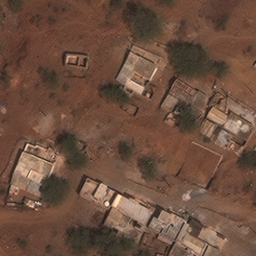

  0%|                                                                              | 1/1477 [00:33<13:41:37, 33.40s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 25.86: The buildings are dispersed with no clear clustering or formation.
score 25.37: Overall, the buildings in the aerial image appear to be scattered around without any significant clustering or formations.
score 25.32: The buildings are spread out with no apparent formation.
score 24.11: The buildings are dispersed across the image with no clear pattern.
score 24.05: The buildings are dispersed throughout the image, with some located closer together than others.

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 34.15: Overall, the buildings in the aerial image appear to be scattered around without any significant clustering or formations.
score 33.11: A few scattered buildings can be observed throughout the aerial image.
score 32.59: The buildings are dispersed across the image with no clear pattern.
score 31.81: The buildings are dispersed throughout the image, with some located closer together than others.
score 31.70: A damaged build

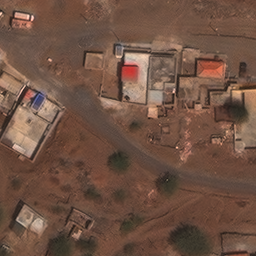

  0%|                                                                              | 2/1477 [01:08<13:53:26, 33.90s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 25.86: The truck and shed are located in the top left corner of the image, far away from other objects.
score 25.56: Two clusters of buildings visible in top right and middle left, with other objects scattered throughout.
score 24.99: Truck, shed and smaller building in top left dispersed.
score 24.96: Two sizable buildings, two construction sites, and one shed can be seen but there is no apparent clustering or encirclement.
score 24.93: The buildings in the middle left of the image form a line, while a truck and a shed are located in the top left corner.

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 31.47: Two sizable buildings, two construction sites, and one shed can be seen but there is no apparent clustering or encirclement.
score 31.32: Two construction sites are present in the top right corner of the image and are very close to each other, indicating ongoing construction activity.
score 31.28: There are four buildings and two con

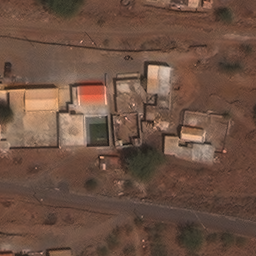

  0%|▏                                                                             | 3/1477 [01:45<14:15:48, 34.84s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 25.23: Several smaller buildings are dispersed throughout the image.
score 25.19: Buildings are scattered throughout the image with no clear clustering or formation.
score 24.25: The buildings are dispersed throughout the image.
score 24.00: A building is positioned in the middle left of the image, with no apparent nearby companions.
score 23.94: The buildings are dispersed throughout the image, forming no significant pattern.

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 31.55: Multiple buildings of different sizes are found scattered throughout the aerial image with no observable spatial clustering.
score 31.40: Six buildings scattered across the aerial image. The largest building is located in the center surrounded by five smaller structures.
score 30.29: Various buildings create an interesting visual composition in different areas of the aerial image.
score 29.75: Six buildings scattered throughout the image, with no distinct spatia

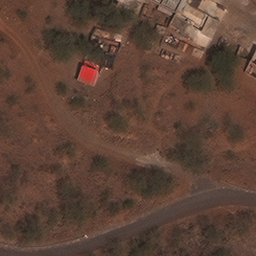

  0%|▏                                                                             | 4/1477 [02:23<14:39:51, 35.84s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 24.02: An isolated building in the top left of the image.
score 23.45: Isolated building in the top right corner, surrounded by ample space.
score 22.32: The construction site is not adjacent to any other objects.
score 22.19: The buildings are dispersed unevenly, with no clear formation or pattern emerging.
score 22.16: Objects dispersed, with buildings and construction site scattered throughout the image.

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 29.98: Four buildings and one construction site are dispersed across the aerial image.
score 29.86: A small cluster of buildings in the top right gives way to scattered structures that dominate the image.
score 29.34: An isolated building in the top left of the image.
score 28.89: The buildings and construction site captured in this image are dispersed throughout, with no significant spatial pattern present.
score 28.84: A construction site draws the eye, located towards the center top of

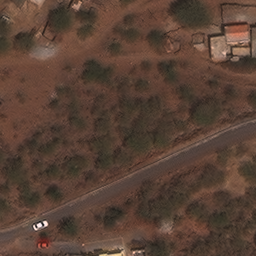

  0%|▎                                                                             | 5/1477 [02:58<14:35:08, 35.67s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 24.69: Two small cars scattered in the bottom left of the image.
score 23.95: The two small cars are dispersed in the bottom-left corner of the aerial image, with one car positioned slightly below the other.
score 23.94: Two small cars located far apart.
score 23.82: Two small cars are dispersed in the bottom left corner of the image.
score 23.65: The two small cars are dispersed in the bottom left corner of the image

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 31.62: The two small cars are dispersed in the bottom-left corner of the aerial image, with one car positioned slightly below the other.
score 30.41: Two small cars are dispersed in the bottom left corner of the image.
score 29.98: The two small cars are dispersed in the bottom left corner of the image
score 29.87: Two small cars scattered in the bottom left of the image.
score 29.62: The two small cars are adjacent to each other in the bottom left corner of the image.

>>>> Ch

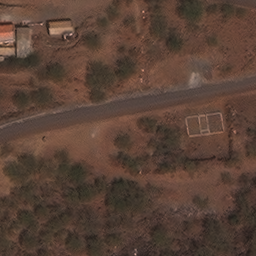

  0%|▎                                                                             | 6/1477 [03:41<15:21:42, 37.60s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 21.70: There is dispersion of objects throughout the image.
score 21.21: The construction site is located in the middle right of the image, far from the other objects.
score 21.07: There are no significant spatial patterns of clustering or formation in the image.
score 21.00: Building two is located away from the other objects.
score 20.67: The construction site is located separately from the other objects in the middle right of the image.

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 28.65: The four buildings are dispersed throughout the aerial image, with no one area being overly crowded.
score 28.39: A construction site dominates the right half of the image, with no other structures nearby.
score 28.36: The construction site is located in the middle right of the image, far from the other objects.
score 28.28: The buildings form a small cluster in the top left corner of the aerial image.
score 28.18: The construction site is located i

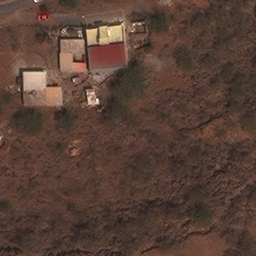

  0%|▎                                                                             | 7/1477 [04:07<13:58:53, 34.24s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 26.94: A small car and four buildings are scattered individually across two areas on an aerial image.
score 26.58: A small car is located in the top left corner of the image, with no other objects nearby.
score 25.34: The small car is located in the top left corner near scattered buildings.
score 25.13: There is a small car located towards the top left corner of the image.
score 24.62: Small car isolated in bottom left.

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 33.76: A small car and four buildings are scattered individually across two areas on an aerial image.
score 31.49: The small car is located in the top left corner near scattered buildings.
score 31.46: A single, dominating building stands alone in the center, surrounded by open space, while several smaller buildings are clustered towards the top left corner of the aerial imagery.
score 30.94: Three buildings cluster together in the top left area of the aerial image, while one

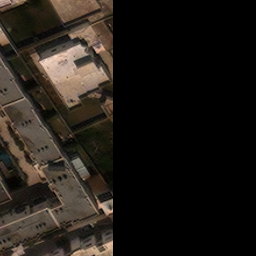

  1%|▍                                                                             | 8/1477 [04:36<13:19:10, 32.64s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 25.83: The buildings are dispersed throughout the image without any discernible formation or adjacency.
score 25.71: Six buildings are dispersed across the image, with no clear pattern of adjacency or clustering.
score 25.61: The image shows a dispersion of buildings, with various structures scattered throughout.
score 25.50: The buildings are dispersed throughout the image, with no particular pattern or arrangement.
score 25.49: There are two large buildings located in opposite corners and several smaller buildings distributed throughout the image.

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 31.77: The aerial image shows buildings scattered across the image in a dispersed pattern without any significant spatial association.
score 31.48: The six buildings are dispersed across the entire image, with no clear encirclement or interposition pattern.
score 31.04: The aerial image shows six buildings dispersed throughout.
score 30.90: Five 

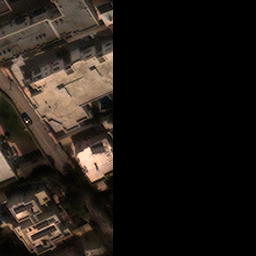

  1%|▍                                                                             | 9/1477 [05:05<12:51:55, 31.55s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 26.06: Building 5 stands out in the center, while other buildings are scattered around it.
score 25.92: Buildings are dispersed throughout the image, with one small car in the middle left.
score 25.84: Similar sized buildings are dispersed throughout the image with no apparent pattern.
score 25.74: The buildings are dispersed throughout the image without any noticeable formation.
score 25.63: Multiple buildings are dispersed throughout the image in no particular pattern.

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 32.87: The aerial image shows several buildings and a small car, distributed across the image without an apparent spatial pattern.
score 32.71: The aerial view displays a jumbled placement of buildings and a car with no apparent pattern.
score 31.86: Two building clusters are at top left and bottom left corners of the aerial image.
score 31.68: Two clusters of buildings can be found in the top left and bottom left corners of

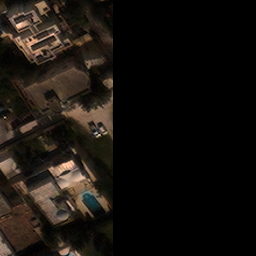

  1%|▌                                                                            | 10/1477 [05:43<13:40:15, 33.55s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 25.30: The buildings are dispersed around the image, with no specific arrangement.
score 25.10: The image depicts a dispersed arrangement with buildings scattered throughout and two small cars in different areas.
score 24.73: The buildings seem to be dispersed throughout the image with no clear formation pattern.
score 24.73: Three clusters of buildings dispersed throughout the image.
score 24.34: The buildings in the image form a cluster in the bottom left corner, with one off to the top left.

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 32.06: Buildings of varying sizes are scattered across the aerial view, with no clear spatial pattern.
score 31.44: Six buildings of varying sizes are dispersed throughout the aerial image at different coordinates.
score 31.06: The aerial image depicts buildings of varying sizes dispersed across the image with two small cars positioned in isolated pockets.
score 31.04: Two small cars are located in th

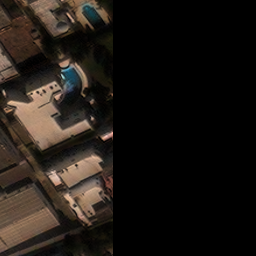

  1%|▌                                                                            | 11/1477 [06:16<13:35:49, 33.39s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 25.38: The buildings are clustered closely together on the left side of the image.
score 25.22: Despite their different sizes, the buildings are uniformly dispersed throughout the image.
score 25.22: The buildings are scattered throughout the image, forming no discernible pattern or shape.
score 25.20: Buildings of varying sizes are dispersed throughout the image.
score 25.12: Aerial view of five buildings, dispersed throughout the image.

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 31.94: The buildings are scattered on the aerial view and appear to be independent of each other.
score 31.81: Aerial view of five buildings, dispersed throughout the image.
score 31.54: The buildings are scattered around the image, with no clear pattern of adjacency or clustering.
score 30.80: The buildings are clustered closely together on the left side of the image.
score 30.73: Five structures are visible on the aerial image, located in various position

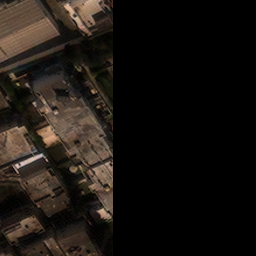

  1%|▋                                                                            | 12/1477 [06:51<13:45:31, 33.81s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 25.59: The buildings are randomly placed throughout the image, with no apparent clustering or organization.
score 25.33: Buildings are dispersed throughout the image of varying sizes.
score 25.30: The buildings are spread across the image, with no discernible spatial relationship between them.
score 25.19: Buildings are dispersed throughout the image with no clear arrangement.
score 25.17: The buildings in the image are dispersed, without any significant clustering patterns observed.

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 32.35: The buildings are scattered across the aerial image, with no clear patterns or groupings.
score 30.62: Multiple buildings are dispersed throughout the image, with varying sizes and no distinct spatial patterns.
score 30.57: Some buildings are located in close proximity to each other, specifically in the bottom left corner of the image.
score 30.48: Task 3: One building is located far from the others at th

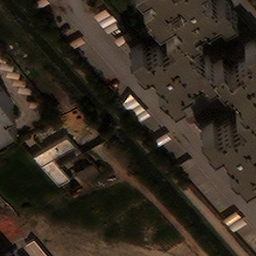

  1%|▋                                                                            | 13/1477 [07:31<14:27:53, 35.57s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 25.49: The dispersed buildings range in size, with a small car positioned relatively far away.
score 24.61: The buildings are clustered towards the top right, while the small car is situated away from them.
score 24.53: The buildings are clustered in two pairs, one on each side of the image, with a small car in the center.
score 24.46: The buildings form a rectangle, with a small car in the upper center of the image.
score 24.38: Buildings dispersed throughout the image, with none in close proximity to each other.

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 33.68: Grouped buildings in corners with a small car in the center-top of the aerial image.
score 33.05: Four buildings and a small car are scattered throughout the aerial image, with no discernible spatial arrangement.
score 32.84: Four buildings scattered throughout the aerial image with no noticeable spatial pattern.
score 32.78: The aerial image displays a dispersion of four bu

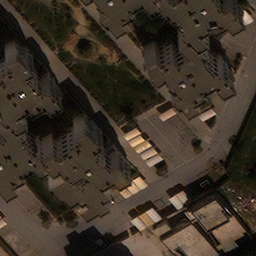

  1%|▋                                                                            | 14/1477 [08:13<15:15:02, 37.53s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 26.63: Two distinct clusters of buildings are present, with a small car located within the left cluster.
score 26.59: The buildings are dispersed throughout the image, forming no distinct pattern.
score 26.12: Buildings are evenly distributed across the image, creating a sense of organization.
score 26.10: The buildings in the image form a pattern of dispersed clusters, with no apparent regularity.
score 25.75: The buildings in the image are dispersed throughout, but there is clustering on the right side.

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 33.11: The buildings are dispersed throughout the image, forming no distinct pattern.
score 32.75: The buildings in the image are dispersed and not clustered together.
score 32.35: The larger buildings are positioned in diagonal corners of the image, with smaller structures in between.
score 32.34: The buildings in the top left and bottom right corners are slightly further away from the oth

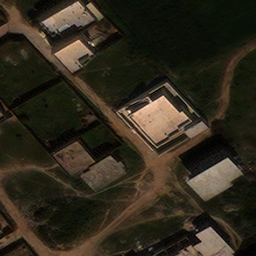

  1%|▊                                                                            | 15/1477 [09:11<17:44:52, 43.70s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 24.99: The buildings are spread apart with no visible roads or paths, indicating the area could be remote or sparsely populated.
score 23.85: The buildings are dispersed throughout the image without any significant clustering or formation.
score 23.69: The buildings are dispersed across the image with no specific pattern.
score 23.39: The aerial image depicts five buildings of varying size dispersed across a landscape with no significant spatial patterns observed.
score 23.37: Although there is no clear pattern, the buildings are located in a way that covers different areas of the image.

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 31.79: Multiple buildings of different sizes are randomly distributed across the aerial image.
score 31.45: The aerial image depicts five buildings of varying size dispersed across a landscape with no significant spatial patterns observed.
score 30.62: The buildings in this aerial image are scattered and do 

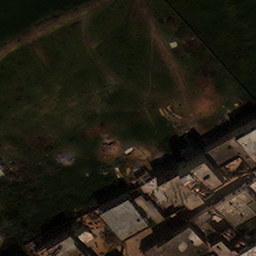

  1%|▊                                                                            | 16/1477 [09:41<16:06:06, 39.68s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 24.52: The buildings are dispersed throughout the image.
score 24.27: A single building stands alone, located far away from the other buildings in the bottom left corner of the aerial image.
score 23.86: The image shows a collection of random, disconnected buildings positioned throughout the frame.
score 23.70: A single building stands alone in the bottom left corner of the image.
score 23.65: A cluster of two buildings in the bottom right corner of the image.

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 32.28: Several lone buildings of varying sizes are scattered across an aerial image.
score 32.07: A single building stands alone, located far away from the other buildings in the bottom left corner of the aerial image.
score 31.01: A single building stands alone in the bottom left corner of the image.
score 30.42: Aerial view of scattered buildings without a clear cluster or formation.
score 30.39: One building is isolated in the botto

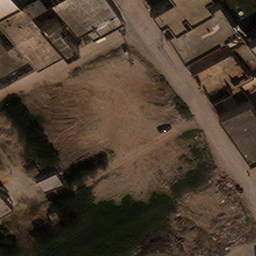

  1%|▉                                                                            | 17/1477 [10:19<15:53:39, 39.19s/it]

>>>> ChatGPT ranked with CLIP RSICD: <<<<
score 25.52: The buildings are scattered throughout the image, without any clear formation or encirclement.
score 25.28: The small car located in the middle right appears insignificant and isolated in comparison to the larger buildings in the image.
score 24.91: The buildings do not appear to form any distinct shape or pattern and are dispersed throughout the image.
score 24.72: There is a mixture of small and large structures dispersed throughout the image.
score 24.69: The rest of the buildings and the car are dispersed throughout the image.

>>>> ChatGPT ranked with CLIP ONLY: <<<<
score 31.20: The buildings are scattered throughout the image, without any clear formation or encirclement.
score 29.57: The building at the bottom left and the small car at the middle right of the image show no significant spatial patterns.
score 29.54: The two buildings located in the top left of the image form a clustering spatial pattern.
score 29.34: A small 

Token indices sequence length is longer than the specified maximum sequence length for this model (105 > 77). Running this sequence through the model will result in indexing errors
  1%|▉                                                                            | 17/1477 [11:00<15:45:27, 38.85s/it]


RuntimeError: The size of tensor a (105) must match the size of tensor b (77) at non-singleton dimension 1

In [11]:
for key, captions in tqdm(responses.items()):
    image = Image.open(os.path.join(image_root, f"{key}.png"))
    captions_with_title = [f"ChatGPT: {cap}" for cap in captions]
    
    git_inputs = git_processor(images=image, return_tensors="pt")
    generated_ids = git_model.generate(
        pixel_values=git_inputs.pixel_values, 
        max_length=256,
        do_sample=True,
        top_k=50, 
        top_p=0.95, 
        num_return_sequences=3
    )
    generated_captions = git_processor.batch_decode(generated_ids, skip_special_tokens=True)
    generated_captions_with_title = [f"GIT: {cap}" for cap in generated_captions]
    
    rsicd_git_inputs = processor(text=generated_captions, images=image, return_tensors="pt", padding=True)
    inputs = processor(text=captions, images=image, return_tensors="pt", padding=True)
    
    rsicd_scores = model(**inputs).logits_per_image[0].detach().numpy()
    rsicd_git_scores = model(**rsicd_git_inputs).logits_per_image[0].detach().numpy()
    
    rsicd_selected_indices = np.argsort(-rsicd_scores)[:5]
    
    
    clip_scores = clip_model(**inputs).logits_per_image[0].detach().numpy()
    clip_scores = model(**rsicd_git_inputs).logits_per_image[0].detach().numpy()
    clip_selected_indices = np.argsort(-clip_scores)[:5]
    
    joint_scores = 0.8 * rsicd_scores + 0.2 * clip_scores
    joint_selected_indices = np.argsort(-joint_scores)[:5]
    

    generated_captions = git_processor.batch_decode(generated_ids, skip_special_tokens=True)
    
    display(image)
    
    print(">>>> ChatGPT ranked with CLIP RSICD: <<<<")
    for i in rsicd_selected_indices:
        print(f"score {rsicd_scores[i]:.2f}: {captions[i]}")
        
    print()
    print(">>>> ChatGPT ranked with CLIP ONLY: <<<<")
    for i in clip_selected_indices:
        print(f"score {clip_scores[i]:.2f}: {captions[i]}")
        
    print()
    print(">>>> ChatGPT ranked with BOTH CLIP: <<<<")
    for i in joint_selected_indices:
        print(f"score {joint_scores[i]:.2f}: {captions[i]}")
    
    print()
    print(">>>> GIT Captions: <<<<")
    for gen_cap in generated_captions:
        print(gen_cap)

In [80]:
all_captions = []
samples_indices = []
records_indices = []

for key_idx, key in tqdm(enumerate(samples_keys)):
    sim_record = {}
    for record_id, record in records.items():
        sim_record[record_id] = record.get(key, [])
        
    for record_key, captions in sim_record.items():
        record_idx = records_keys.index(record_key)
        valid_captions = [cap for cap in captions if len(tokenizer.tokenize(cap)) <= 75]
        if len(valid_captions) < 70:
            continue
            
        all_captions.extend(valid_captions)
        samples_indices.extend([key_idx] * len(valid_captions))
        records_indices.extend([record_idx] * len(valid_captions))


0it [00:00, ?it/s]
1it [00:00,  3.82it/s]
2it [00:00,  3.84it/s]
3it [00:00,  3.96it/s]
4it [00:00,  4.04it/s]
5it [00:01,  4.20it/s]
6it [00:01,  4.31it/s]
7it [00:01,  4.40it/s]
8it [00:01,  4.37it/s]
9it [00:02,  3.94it/s]
10it [00:02,  4.01it/s]
11it [00:02,  4.10it/s]
12it [00:02,  4.14it/s]
13it [00:03,  4.36it/s]
14it [00:03,  4.35it/s]
15it [00:03,  4.42it/s]
16it [00:03,  4.48it/s]
17it [00:03,  4.50it/s]
18it [00:04,  4.55it/s]
19it [00:04,  4.46it/s]
20it [00:04,  4.32it/s]
21it [00:04,  4.40it/s]
22it [00:05,  4.33it/s]
23it [00:05,  4.44it/s]
24it [00:05,  4.49it/s]
25it [00:05,  4.50it/s]
26it [00:06,  4.46it/s]
27it [00:06,  4.33it/s]
28it [00:06,  4.36it/s]
29it [00:06,  4.37it/s]
30it [00:06,  4.44it/s]
31it [00:07,  4.49it/s]
32it [00:07,  4.42it/s]
33it [00:07,  4.38it/s]
34it [00:07,  4.41it/s]
35it [00:08,  4.24it/s]
36it [00:08,  4.18it/s]
37it [00:08,  4.20it/s]
38it [00:08,  4.21it/s]
39it [00:09,  4.31it/s]
40it [00:09,  4.32it/s]
41it [00:09,  4.30it/s]
42it 

In [81]:
match_scores = np.zeros(len(all_captions))

In [82]:
start_time = time.time()
for idx, key in tqdm(enumerate(samples_keys)):
    sample_indices = [i for i, cap in enumerate(all_captions) if samples_indices[i] == idx]
    sample_captions = [all_captions[i] for i in sample_indices]
    # sample_records = [records_indices[i] for i, cap in enumerate(all_captions) if samples_indices[i] == sample_idx]

    if (match_scores[sample_indices] == 0).sum() == 0:
        print(f"idx {idx} has been done. Continue")
        continue
    
    for i in range(0, len(sample_captions), 50):
        slice_indices = sample_indices[i:i+50]
        slice_captions = sample_captions[i:i+50]
        
        inputs = processor(text=slice_captions, images=images[idx], return_tensors="pt", padding=True)
        outputs = model(**inputs).logits_per_image[0].detach().numpy()
        match_scores[slice_indices] = outputs
end_time = time.time()
print(end_time - start_time) 


0it [00:00, ?it/s]
1it [00:30, 30.35s/it]
2it [01:06, 32.11s/it]
3it [01:37, 31.81s/it]
4it [02:10, 32.22s/it]
5it [02:53, 35.22s/it]
6it [03:28, 35.28s/it]
7it [04:00, 34.31s/it]
8it [04:29, 32.76s/it]
9it [05:01, 32.37s/it]
10it [05:35, 32.93s/it]
11it [06:10, 33.46s/it]
12it [06:42, 33.10s/it]
13it [07:09, 31.45s/it]
14it [07:43, 32.22s/it]
15it [08:15, 31.95s/it]
16it [08:48, 32.21s/it]
17it [09:19, 32.02s/it]
18it [09:51, 31.82s/it]
19it [10:22, 31.82s/it]
20it [10:55, 32.03s/it]
21it [11:25, 31.43s/it]
22it [11:55, 31.14s/it]
23it [12:26, 31.00s/it]
24it [12:57, 31.08s/it]
25it [13:30, 31.62s/it]
26it [14:03, 31.84s/it]
27it [14:32, 31.26s/it]
28it [15:02, 30.87s/it]
29it [15:32, 30.53s/it]
30it [16:01, 29.96s/it]
31it [16:32, 30.46s/it]
32it [17:02, 30.26s/it]
33it [17:31, 29.88s/it]
34it [18:00, 29.63s/it]
35it [18:32, 30.28s/it]
36it [19:03, 30.49s/it]
37it [19:35, 30.87s/it]
38it [20:06, 30.86s/it]
39it [20:34, 30.27s/it]
40it [21:05, 30.34s/it]
41it [21:35, 30.23s/it]
42it 

2551.127875804901


In [126]:
for i, key in enumerate(records_keys):
    
    scores = match_scores[np.array(records_indices) == i]
    print(key)
    print(scores.shape)
    print(scores.mean())
    print(scores.std())
    

0_0
(5266,)
21.602052852313328
2.197008422019524
0_1
(8145,)
21.145144394909114
2.3749839806832513
0_10
(7643,)
21.050573482261377
2.496387817911768
0_2
(8173,)
21.116528355271612
2.341249002809695
0_3
(7584,)
21.083072877005687
2.457297100705515
0_4
(7803,)
21.12413204197515
2.473613801516891
0_5
(7908,)
20.954446864116054
2.562721101106644
0_6
(7962,)
20.973878650023273
2.5961284707319883
0_7
(6923,)
21.193824151339566
2.273691411253815
0_8
(7933,)
21.11615548493897
2.45088677412625
0_9
(7935,)
21.142657722131815
2.488920514971912


In [164]:
scores_df = pd.DataFrame(scores_with_indices.transpose(), columns=["score", "sample_id", "record_id"])
scores_df["caption"] = all_captions
scores_grouped_df = scores_df.groupby(["sample_id", "record_id"]).agg({"score": "median"}).reset_index()

In [165]:
full_df = scores_df.merge(samples_df, how="left", left_on="sample_id", right_on="index")

In [166]:
full_df

,score,sample_id,record_id,caption,index,key,length,nunique,objects
0,22.606125,0.0,0.0,Buildings cluster in the bottom right and a sm...,0,102.tif_138,9,2,"[SmallCar, Building, Building, Building, Build..."
1,21.856197,0.0,0.0,One building is surrounded by others forming a...,0,102.tif_138,9,2,"[SmallCar, Building, Building, Building, Build..."
2,23.874626,0.0,0.0,"Some buildings are dispersed on the image, not...",0,102.tif_138,9,2,"[SmallCar, Building, Building, Building, Build..."
3,23.394234,0.0,0.0,Buildings in formation form a line from the bo...,0,102.tif_138,9,2,"[SmallCar, Building, Building, Building, Build..."
4,21.054209,0.0,0.0,Two small cars are situated at opposite corner...,0,102.tif_138,9,2,"[SmallCar, Building, Building, Building, Build..."
...,...,...,...,...,...,...,...,...,...
83270,21.896088,84.0,10.0,The aerial image depicts several damaged build...,84,94.tif_60,6,1,"[DamagedBuilding, DamagedBuilding, DamagedBuil..."
83271,19.944523,84.0,10.0,"One of the buildings is prominently sized, cen...",84,94.tif_60,6,1,"[DamagedBuilding, DamagedBuilding, DamagedBuil..."
83272,20.868423,84.0,10.0,Two smaller damaged buildings are situated clo...,84,94.tif_60,6,1,"[DamagedBuilding, DamagedBuilding, DamagedBuil..."
83273,21.078648,84.0,10.0,The buildings don't follow any specific format...,84,94.tif_60,6,1,"[DamagedBuilding, DamagedBuilding, DamagedBuil..."


In [169]:
for name, group in full_df.groupby("key"):
    good_ones = group.sort_values("score", ascending=False).head(20)
    bad_ones = group.sort_values("score", ascending=True).head(20)
    print(name)
    print(good_ones[["score", "caption"]].values.tolist())
    print(bad_ones[["score", "caption"]].values.tolist())


102.tif_138
[[25.628204345703125, 'The buildings are scattered throughout the image, with no apparent pattern or alignment.'], [25.595693588256836, 'Some buildings and the two small cars are randomly scattered throughout the aerial image.'], [25.245601654052734, 'The buildings are dispersed across the image with no clear clustering or formations.'], [25.187225341796875, 'The buildings are spread out around the image, not forming any distinct patterns.'], [25.032978057861328, 'Seven buildings and two small cars are randomly scattered throughout the aerial image.'], [24.91878318786621, 'A group of buildings occupies the lower half, while two solitary structures flank the middle, each with a car nearby.'], [24.790733337402344, 'The buildings present in the image showcase the various styles of architecture found in urban settings.'], [24.74860191345215, 'The two small cars serve as the sole signs of human activity in this vast, peaceful landscape, flanking the eight buildings scattered thr

[[13.532957077026367, 'Aerial view of cityscape with distinct clusters of buildings.'], [14.058876037597656, 'A sprawling cityscape spreads out across the image, featuring buildings of different sizes and location.'], [14.116768836975098, 'Buildings of various sizes and positions are scattered throughout the image, creating a varied cityscape.'], [14.209754943847656, 'A cluster of buildings dominates the top center of the image, while buildings are dispersed towards the edges.'], [14.425081253051758, 'A distinct vertical pattern of buildings is visible running from the top left towards the middle right, with varying sizes.'], [14.486394882202148, 'Buildings organize into highly contrasting clusters that arrange into a pleasing pattern filled with negative space.'], [14.613829612731934, 'A cluster of large buildings dominates the top left corner, while smaller buildings are scattered throughout the rest of the image.'], [14.697113037109375, 'A line of buildings form the top edge, while 

In [144]:
full_df[["score", "nunique"]].corr()

,score,nunique
score,1.000000,0.415965
nunique,0.415965,1.000000


In [84]:
scores_with_indices = np.stack((match_scores, np.array(samples_indices), np.array(records_indices)))

with open('results/rsicd-clip_match_scores.npy', 'wb') as f:
    np.save(f, scores_with_indices)

In [88]:
match_scores.shape

(83275,)

In [90]:
len(samples_indices)

83275

In [57]:
def t_test(a, b):
    min_size = min(len(a), len(b))
    
    sample_a = a
    sample_b = b
    
    if min_size != len(sample_a):
        sample_a = np.random.choice(a, min_size, replace=False)
    if min_size != len(sample_b):
        sample_b = np.random.choice(b, min_size, replace=False)
        
    return ttest_ind(sample_a, sample_b)

In [16]:
sim_records = {}

for key in tqdm(samples.keys()):
    sim_record = {}
    for record_id, record in records.items():
        captions = record.get(key, [])
        if len(captions) == 0:
            continue
        
        inputs = processor(text=captions, images=image, return_tensors="pt", padding=True)
        logits = model(**inputs).logits_per_image[0].detach().numpy()
        sorted_logits = logits[np.argsort(logits)[::-1]]
        sim_record[record_id] = sorted_logits
    
    lengths = [value.shape[0] for value in sim_record.values()]
    
    if min(lengths) < 16:
        continue
        
    sim_records[key] = sim_record

  0%|                                                                                           | 0/85 [00:00<?, ?it/s]


NameError: name 'image' is not defined

In [21]:
sorted_logits

array([31.350168, 31.025824, 30.901922, 30.515787, 30.386406, 30.236092,
       30.185266, 30.05999 , 29.993208, 29.98081 , 29.925995, 29.623564,
       29.597374, 29.45525 , 29.43065 , 29.232107, 29.214981, 29.188152,
       29.006079, 28.98182 , 28.721973, 28.583952, 28.366207, 28.343855,
       28.219797, 28.18656 , 28.086308, 28.065895, 28.054441, 27.941397,
       27.932589, 27.834793, 27.71163 , 27.646627, 27.616869, 27.603762,
       27.496286, 27.431639, 27.413095, 27.407822, 27.279213, 27.194002,
       27.080276, 27.059748, 27.037437, 26.989027, 26.89038 , 26.798405,
       26.78367 , 26.74097 , 26.613094, 26.39619 , 26.322653, 26.301308,
       26.28823 , 26.179272, 26.138912, 26.11029 , 26.09074 , 25.8043  ,
       25.759514, 25.46328 , 25.459604, 25.423025, 25.395092, 25.23114 ,
       25.156092, 24.675657, 24.671854, 24.612137, 24.602262, 24.47859 ,
       24.261518, 24.23877 , 24.179085, 24.01067 , 23.921213, 23.321102,
       23.029516, 22.571487, 22.369669, 19.530396],

In [64]:
captions_array[sorted_indices]

array(['Several buildings form a diagonal line across the image, ranging in size from large to small.',
       'Buildings are sparsely scattered across the image, the largest one stands out in the upper right corner.',
       'The buildings in the lower half of the image form a diagonal line',
       'Aerial view reveals an intricate assortment of buildings in diamond formation, highlighting the largest structure at the top-right corner.',
       'A cluster of buildings, ranging from small to large sizes, are evenly distributed throughout the image.',
       'A dominant building stands out among smaller structures in this aerial view',
       'The organized layout of the buildings in this aerial image is accentuated by the carefully positioned small cars in the corners.',
       'The buildings in this aerial image are arranged in a diagonal line and two small cars bookend the corners.',
       'The buildings in this aerial image are arranged in a diagonal line while the small cars fram

In [12]:
kmeans = faiss.Kmeans(embedding.shape[1], 5, niter=20, verbose=True)
kmeans.train(embedding[:30])

NameError: name 'embedding' is not defined

In [79]:
index = faiss.IndexFlatL2(embedding.shape[1])
index.add(embedding)
D, I = index.search(kmeans.centroids, 2)

In [40]:
records_10.keys()

dict_keys(['10.tif_18', '10.tif_19', '10.tif_31', '10.tif_32', '10.tif_33', '10.tif_34', '10.tif_35', '10.tif_45', '10.tif_46', '10.tif_47', '10.tif_48', '10.tif_60'])

In [80]:
for i in range(I.shape[0]):
    print([captions[i] for i in I[i, :]])

['Top and bottom right buildings cluster.', 'Clustered buildings in top right and center.']
['Mostly horizontal/vertical alignment', 'Unique damage patterns top left and center']
['Damaged buildings in top left and center top.', 'Damaged buildings are concentrated in the top left and center top, indicating a possible cause or target of the damage.']
['The construction sites in the center of the image are interposed by buildings in the top right and bottom right.', 'Buildings are dispersed across the image, except for one in the middle bottom where a construction site is located.']
['Hut or tent separate in top right', 'The hut or tent in the top right stands out amidst the permanent structures, suggesting a different social or economic status.']
